In [1]:
import argparse
import numpy as np
import pickle
import time
import torch
import torch.nn as nn
import torch.optim as optim


from dataset import get_dataloader
from tqdm import tqdm
import random
from models.gated_tpp import *
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
data = '../data/simulated/power_hawkes/'
batch_size = 1
def load_data(name, dict_name):
    with open(name, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
        num_types = data['dim_process']
        data = data[dict_name]
        return data, int(num_types)

train_data, num_types = load_data(data + 'train.pkl', 'train')
dev_data, _ = load_data(data + 'dev.pkl', 'dev')
test_data, _ = load_data(data + 'test.pkl', 'test')


trainloader = get_dataloader(train_data, batch_size, shuffle=True)
testloader = get_dataloader(test_data, 1, shuffle=False)
valloader = get_dataloader(dev_data, batch_size, shuffle=False)

In [3]:
model = gated_TPP(1, 32, t_max=200)
lr  = 0.01
epochs = 5

optimizer = optim.Adam(filter(lambda x: x.requires_grad, model.parameters()),
                       lr, betas=(0.9, 0.999), eps=1e-05)
scheduler = optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5)

for epoch in range(epochs):
    epoch_loss = 0
    total_events =0
    for batch in trainloader:

        optimizer.zero_grad()

        event_type = batch[2]
        event_time = batch[0]
        arrival_time = batch[1]
        predicted_times = model(event_type,event_time)




        batch_loss = model.calculate_loss(arrival_time,predicted_times,event_type)
        epoch_loss +=batch_loss
        total_events += ((event_type!=0).sum(-1)-1).sum()

        batch_loss.backward()
        optimizer.step()

    train_loss = epoch_loss/total_events
    
    print('Epoch:{}, Loss:{}'.format(epoch,train_loss))


Epoch:0, Loss:3.038167953491211
Epoch:1, Loss:3.036944627761841
Epoch:2, Loss:3.037116289138794
Epoch:3, Loss:3.037158966064453
Epoch:4, Loss:3.0368309020996094


## Kernel Predictions

In [4]:
kernel_values = []
all_times = []


for batch in testloader:
    
    event_type = batch[2]
    length = event_type.sum()
    event_time = batch[0]
    arrival_time = batch[1]
    scores, embedding,t_diff = model.encoder(event_type,event_time)


    masked_t_diff = (t_diff[0][:length,:length])
    masked_scores = (scores[0][:length,:length])
    row,column = masked_t_diff.size()
    row,column = torch.tril_indices(row,column)
    times = masked_t_diff[row,column]
    triggering_values=  masked_scores[row,column]
    
    kernel_values.append(triggering_values.detach())
    all_times.append(times.detach())
    
kernel_values = torch.cat(kernel_values)
all_times = torch.cat(all_times)

AttributeError: 'gated_TPP' object has no attribute 't_max'

In [62]:
x = all_times.detach()
y = kernel_values.detach()

sorted_indices = torch.argsort(x)

x = x[sorted_indices]
y = y[sorted_indices]


## Moving Average

step = 0.1

t = []
alpha = []

for i in np.arange(step,200,step):
    avg_index = (x<i) & ( x >i - step)
    t.append(x[avg_index].mean().item())
    alpha.append(y[avg_index].mean().item())

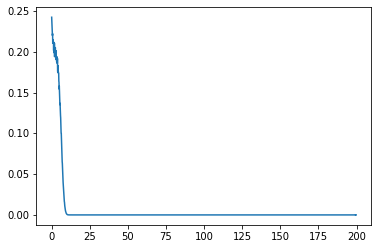

In [63]:
plt.plot(t,alpha)

## Event Predictions

### RMSE Calculations

In [96]:
last_errors = []
all_errors = []

for batch in testloader:
    

    event_type = batch[2]
    event_time = batch[0]
    arrival_time = batch[1]
    predicted_times = model(event_type,event_time)


    last_event_index = event_type.sum(-1)-2
    errors = predicted_times[:, :-1] - arrival_time[:, 1:]
    seq_index = 0
    for idx in last_event_index:
        last_errors.append(errors[seq_index][idx].unsqueeze(-1))
        all_errors.append(errors[seq_index][:idx+1])
        
last_errors = torch.cat(last_errors)
last_RMSE =(last_errors**2).mean().sqrt()


all_errors = torch.cat(all_errors)
all_RMSE = (all_errors**2).mean().sqrt()

RMSE

6.708700064962927

In [95]:
last_errors[0].unsqueeze(-1).shape

torch.Size([1])

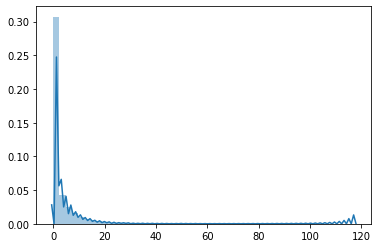

In [66]:
sns.distplot(np.absolute(all_errors.detach()))